# Server Log Analysis

> Akhilesh Muthusamy – C0791987  
> Gursanjam Kaur – C0788089  
> Sai Charitha – C0787250  
> Sweety Patel - C0789805  


In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r'./data/Linux_v2_2.csv')
df.head()

,Date,Time,Hostname,Message,Severity,Process,PID,User,IP,Len
0,2019-06-09,06:06:20,combo,restart.,0,syslogd 1.4.1,NaN,root,127.0.0.1,8
1,2019-06-09,06:06:20,combo,syslogd startup succeeded,0,syslog,NaN,root,127.0.0.1,25
2,2019-06-09,06:06:20,combo,klogd startup succeeded,0,syslog,NaN,root,127.0.0.1,23
3,2019-06-09,06:06:20,combo,"klogd 1.4.1, log source = /proc/kmsg started.",0,kernel,NaN,root,127.0.0.1,45
4,2019-06-09,06:06:20,combo,Linux version 2.6.5-1.358 (bhcompile@bugs.buil...,0,kernel,NaN,root,127.0.0.1,143


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25706 entries, 0 to 25705
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      25706 non-null  object
 1   Time      25706 non-null  object
 2   Hostname  25706 non-null  object
 3   Message   25613 non-null  object
 4   Severity  25706 non-null  int64 
 5   Process   25688 non-null  object
 6   PID       11176 non-null  object
 7   User      25706 non-null  object
 8   IP        25706 non-null  object
 9   Len       25706 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 2.0+ MB


In [4]:
# convert the 'Date' column to datetime format
df['Date'] = df['Date'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25706 entries, 0 to 25705
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      25706 non-null  datetime64[ns]
 1   Time      25706 non-null  object        
 2   Hostname  25706 non-null  object        
 3   Message   25613 non-null  object        
 4   Severity  25706 non-null  int64         
 5   Process   25688 non-null  object        
 6   PID       11176 non-null  object        
 7   User      25706 non-null  object        
 8   IP        25706 non-null  object        
 9   Len       25706 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 2.0+ MB


In [5]:
print(df.shape)

(25706, 10)


# Data Visualization

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

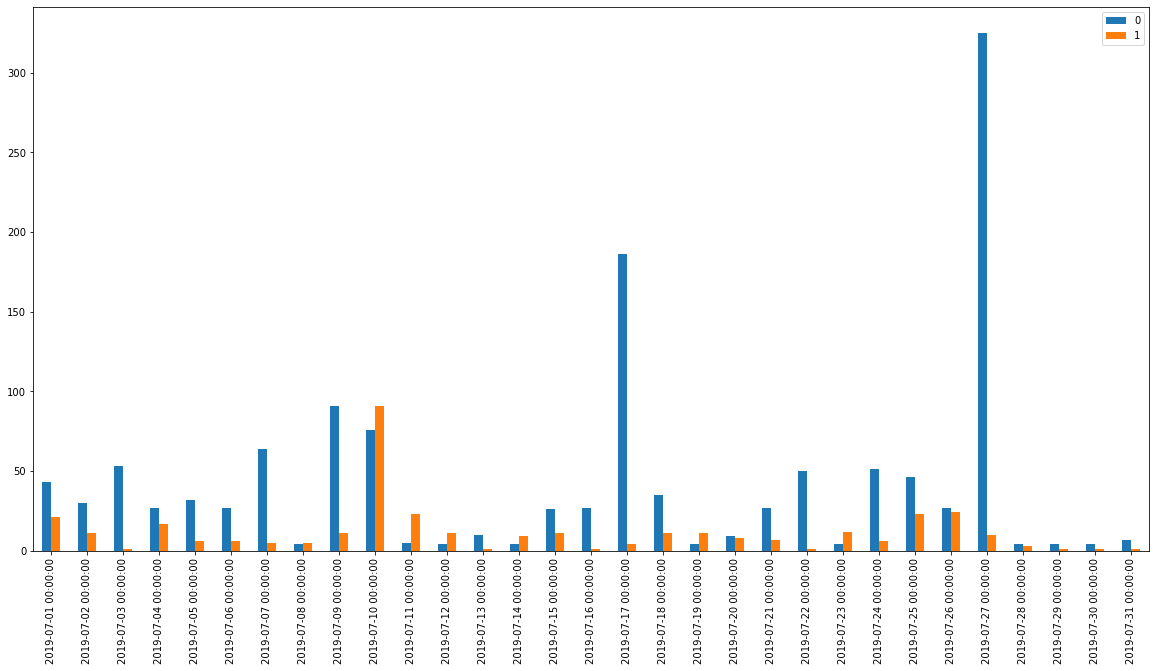

In [7]:
daily_log_count = {}
df_dtgrp = df.groupby('Date')['Severity']
for date, grp in df_dtgrp:
    daily_log_count[date] = dict(grp.value_counts())

df_bar = pd.DataFrame(data=daily_log_count).T
df_bar.index.astype('datetime64[ns]')
df_bar.sort_index(inplace=True)
df_bar.loc['2019-07-01':'2019-07-31'].plot(kind='bar');

## Handling Null values

In [8]:
df.isnull().sum()

Date            0
Time            0
Hostname        0
Message        93
Severity        0
Process        18
PID         14530
User            0
IP              0
Len             0
dtype: int64

In [9]:
df.dropna(subset=['Message'], inplace=True)
df.dropna(subset=['Process'], inplace=True)

In [10]:
import math

def handle_null_pid(id):
    if isinstance(id, str):
        id = id[1:-1]
    elif math.isnan(id):
        id = 0
     
    return id

In [11]:
df['PID'] = df['PID'].apply(handle_null_pid)

In [12]:
df.isnull().sum()


Date        0
Time        0
Hostname    0
Message     0
Severity    0
Process     0
PID         0
User        0
IP          0
Len         0
dtype: int64

## Data Cleaning

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

en_stopwords = set(stopwords.words('english')) 

def clean_content(message: str):

    try:
        # Converting content to lowercase
        message = message.lower()
        # Replace date time string to word TIMESTAMP
        message = re.sub(r"[a-z]{3} [a-z]{3} [0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} [0-9]{4}", 'TIMESTAMP', message)
        # Replace ip-address string to word IPADDRESS
        message = re.sub(r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b", 'IPADDRESS', message)
        # Replace hexa decimal string to word HEXCODE
        message = re.sub(r"\b0x[0-9A-F]+\b", 'HEXCODE', message)
        # Replace URL with word URLORDOMAIN
        message = re.sub(r'(?:https?:\/\/)?([a-zA-Z][a-zA-Z0-9._\-]+.[a-zA-Z0-9]+(\.[a-zA-Z0-9._\-]{2,3})+)', 'URLORDOMAIN', message)
        # Replace numbers to word NUMBER
        message = re.sub(r"\b\d{1,3}\b", 'NUMBER', message)
        # Remove characters apart from alphabets
        message = re.sub('([^A-Za-z ])+', ' ', message)
        # Remove words less than 3 characters
        message = re.sub(r'(\b.{1,2}\s)+', ' ', message)
        # Remove mulitiple whitespace
        message = re.sub(r' +', ' ', message)

        # Removing stopwords & perform stemming
        porter = PorterStemmer()

        clean_str = []
        word_tokens = nltk.word_tokenize(message)
        for word in word_tokens: 
            if word not in en_stopwords:
                clean_str.append(porter.stem(word))
        
        message = ' '.join(clean_str)

        

    except:
        print('Error')
    
    
    return message

In [14]:
df['Message'] = df['Message'].apply(clean_content)
df.sample(10)

,Date,Time,Hostname,Message,Severity,Process,PID,User,IP,Len
23524,2020-01-26,12:22:08,combo,pci hotplug pci hot plug pci core version numb...,0,kernel,0,root,127.0.0.1,47
6181,2019-09-28,09:12:24,combo,remov devic node udev vcsa,0,udev,2452,root,127.0.0.1,34
19329,2019-12-04,16:31:35,combo,memori kill process httpd,1,kernel,0,root,127.0.0.1,43
23129,2020-01-23,06:10:34,combo,authent failur lognam uid number euid number t...,1,sshd(pam_unix),28623,root,127.0.0.1,104
2272,2019-07-13,04:10:41,combo,session open user news uid number,0,su(pam_unix),6863,root,127.0.0.1,39
12797,2019-11-22,13:10:41,combo,memori kill process python,1,kernel,0,root,127.0.0.1,44
25264,2020-02-22,23:41:37,combo,connect ipaddress urlordomain timestamp,0,ftpd,6053,root,24.229.9.65,90
17096,2019-11-30,11:55:22,combo,memori kill process python,1,kernel,0,root,127.0.0.1,44
8725,2019-11-17,04:29:47,combo,check pass user unknown,0,sshd(pam_unix),5130,root,127.0.0.1,24
7929,2019-11-05,06:41:57,combo,connect ipaddress urlordomain sat nov number n...,0,ftpd,11300,root,84.57.172.16,99


### Examples

In [15]:
df.loc[22339]['Message']

'connect ipaddress timestamp'

In [16]:
message = 'User unknown timed out after 900 seconds at Sat Jun 18 02:23:10 2005 '
clean_content(message)

'user unknown time number second timestamp'

In [17]:
message = 'User unknown timed out after 900 seconds at Sat Jun 18 02:23:10 2005 '
re.sub(r"[A-Z][a-z]{2} [A-Z][a-z]{2} [0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} [0-9]{4}", 'TIMESTAMP', message)

'User unknown timed out after 900 seconds at TIMESTAMP '

### Remove duplicate messages

In [18]:
clean_df = df.drop_duplicates(subset='Message', keep = 'first')
clean_df.sample(10)

,Date,Time,Hostname,Message,Severity,Process,PID,User,IP,Len
3367,2019-08-02,08:03:37,combo,close,0,gpm,2076,root,127.0.0.1,7
82,2019-06-09,06:06:21,combo,isapnp scan urlordomain,0,kernel,0,root,127.0.0.1,33
23861,2020-01-26,12:22:43,combo,urlordomain avc deni ioctl pid exe usr sbin hc...,1,kernel,0,root,127.0.0.1,205
11837,2019-11-21,12:41:10,combo,handl fault,1,kernel,0,root,127.0.0.1,39
267,2019-06-09,06:07:16,combo,net snmp urlordomain,0,snmpd,2287,root,127.0.0.1,23
8224,2019-11-10,16:00:31,combo,hda drive readi command,0,kernel,0,root,127.0.0.1,32
23629,2020-01-26,12:22:13,combo,urlordomain item number name proc sy net econet,0,kernel,0,root,127.0.0.1,62
5888,2019-09-28,09:09:17,combo,kernel log daemon termin,1,kernel,0,root,127.0.0.1,30
25273,2020-02-23,12:02:26,combo,authent failur lognam uid number euid number t...,1,sshd(pam_unix),6064,root,80.34.110.175,95
12527,2019-11-22,09:25:55,combo,bdc proc hexcod,1,kernel,0,root,127.0.0.1,34


# Data Preprocessing

In [19]:
from sklearn.model_selection import train_test_split

X = clean_df.drop(columns='Severity', axis=1).iloc[:, 2:].copy()
y = clean_df['Severity'].astype(np.int64).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
X_train = X_train.copy()
X_test = X_test.copy()

## Encoding Categorical data

In [20]:
X_train_encoded = pd.get_dummies(X_train, columns=['Hostname','Process','User','IP'])
X_train_encoded.head()

,Message,PID,Len,Hostname_combo,Hostname_ns1,Process_ -- root,Process_/sbin/mingetty,Process_FreeWnn,Process_PAM-rootok,Process_anacron,...,IP_81.196.56.67,IP_81.240.142.171,IP_82.121.128.139,IP_82.53.83.190,IP_83.114.226.68,IP_84.139.180.196,IP_84.154.98.89,IP_84.232.2.50,IP_84.5.218.32,IP_84.57.172.16
7335,authent fail ipaddress number number number nu...,22519,107,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23891,urlordomain syscal number exit number number f...,0,173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185,microcod cpu alreadi revis hexcod current hexcod,0,53,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4793,connect ipaddress urlordomain wed sep number n...,4289,87,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12760,fput,0,30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Using Count Vector

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['Message'])
X_test_vec = vectorizer.transform(X_test['Message'])

#### SVM

In [22]:
from sklearn import svm
svm_cv = svm.SVC(kernel='linear', probability=True)
svm_cv.fit(X_train_vec, y_train)
predictions_svm_cv = svm_cv.predict(X_test_vec)

from sklearn.metrics import accuracy_score
print("SVM Accuracy Score -> ",accuracy_score(predictions_svm_cv, y_test)*100)

SVM Accuracy Score ->  95.75289575289575


#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vec,y_train)
print("Random Forest Accuracy Score -> ", rf.score(X_test_vec, y_test)*100)

Random Forest Accuracy Score ->  96.13899613899613


#### Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb_cv = MultinomialNB().fit(X_train_vec, y_train)

# predict the labels on validation dataset
predictions_NB_cv = nb_cv.predict(X_test_vec)
# Use accuracy_score function to get the accuracy
from sklearn.metrics import accuracy_score
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB_cv, y_test)*100)

Naive Bayes Accuracy Score ->  93.82239382239382


## Using TF-IDF vector

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(X_train['Message'])
Train_X_Tfidf = Tfidf_vect.transform(X_train['Message'])
Test_X_Tfidf = Tfidf_vect.transform(X_test['Message'])

#### SVM

In [29]:
from sklearn import svm
svm_svc = svm.SVC(kernel='linear', probability=True)
svm_svc.fit(Train_X_Tfidf, y_train)
predictions_svm = svm_svc.predict(Test_X_Tfidf)

from sklearn.metrics import accuracy_score
print("SVM Accuracy Score -> ",accuracy_score(predictions_svm, y_test)*100)

SVM Accuracy Score ->  95.36679536679536


#### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(Train_X_Tfidf, y_train)
print("Random Forest Accuracy Score -> ", rf.score(Test_X_Tfidf, y_test)*100)

Random Forest Accuracy Score ->  96.13899613899613


#### Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(Train_X_Tfidf, y_train)

# predict the labels on validation dataset
predictions_NB = clf.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
from sklearn.metrics import accuracy_score
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  94.20849420849422
